This notebook aims to check the segmentation of high NO2 and the transport of lightning air
at different pressure levels.

Inputs data are generated by `s5p_lnox_main.py` from the S5P-LNO2 repository.

In [1]:
import os
from glob import glob
import xarray as xr
import pandas as pd
import proplot as pplt


# Disable warnings
from warnings import filterwarnings
filterwarnings("ignore")

## Read products

In [2]:
filename = '../data/clean_lightning/S5P_PAL__L2__NO2____20190811T004435_20190811T022605_09458_01_020301.nc'
ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)
ds_lightning = xr.open_dataset(filename, group='Lightning')

## Segmentations

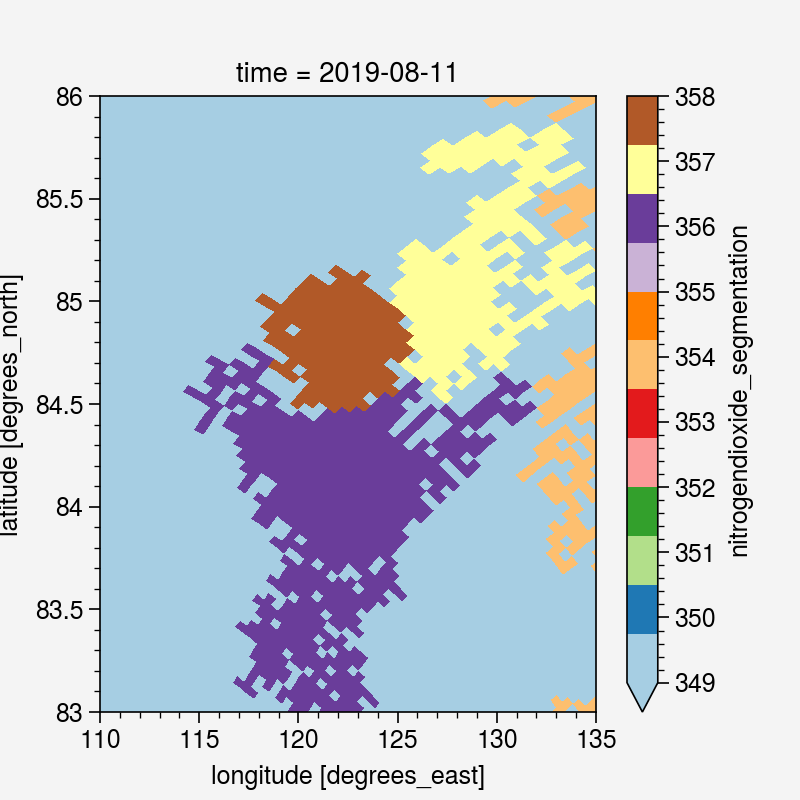

In [3]:
segmentation = ds_tropomi['nitrogendioxide_segmentation']
m = segmentation.plot(x='longitude', y='latitude',
                      xlim=(110, 135), ylim=(83, 86),
                      cmap='Paired',
    vmin=segmentation.where(segmentation>0).quantile(0.9), #add_colorbar=False)
                     )

## Transported lightning air

In [10]:
def plot_scatter(ax, ds_lightning, level):
    s_obs = ax.scatter(ds_lightning['longitude'],
                ds_lightning['latitude'],
                marker="$\u25EF$", cmap='Greys',
                # cmap_kw = {'left': 0.05, 'right': 1},
                c=ds_lightning['delta'], s=6,
                vmax=0,
                # alpha=0.5
                )
    s_transport = ax.scatter(ds_lightning['longitude_pred'].sel(level=level),
                ds_lightning['latitude_pred'].sel(level=level),
                marker="$\u25EF$", cmap='Greens2_r',
                # cmap_kw = {'left': 0.05, 'right': 1},
                c=ds_lightning['delta'], s=6,
                vmax=0,
                # alpha=0.5
                )

    ax.format(title=f'Horizontal transport of lightning NO2 air at {level} hPa')

    return s_obs, s_transport

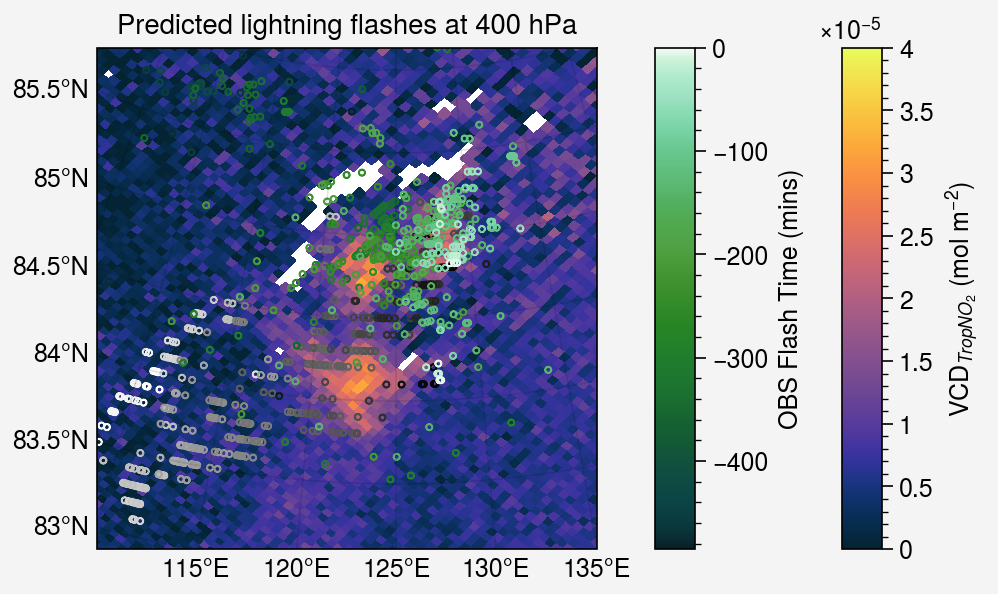

In [5]:
fig, axs = pplt.subplots(proj='stere',
                         proj_kw={'lon_0': 125, 'lat_0': 85})


m = axs.pcolormesh(ds_tropomi['assembled_lon_bounds'],
               ds_tropomi['assembled_lat_bounds'],
               ds_tropomi['nitrogendioxide_tropospheric_column'],
               vmin=0, vmax=4e-5,
               cmap='Thermal', discrete=False,
            #    cmap_kw = {'left': 0.05, 'right': 1},
               )

s_obs, s_transport = plot_scatter(axs, ds_lightning, 400)

fig.colorbar([s_transport], loc='r', label='OBS Flash Time (mins)')
fig.colorbar(m, loc='r', label='VCD$_{TropNO_2}$ (mol m$^{-2}$)')
axs.format(lonlim=(110, 135), latlim=(83, 86), labels=True)

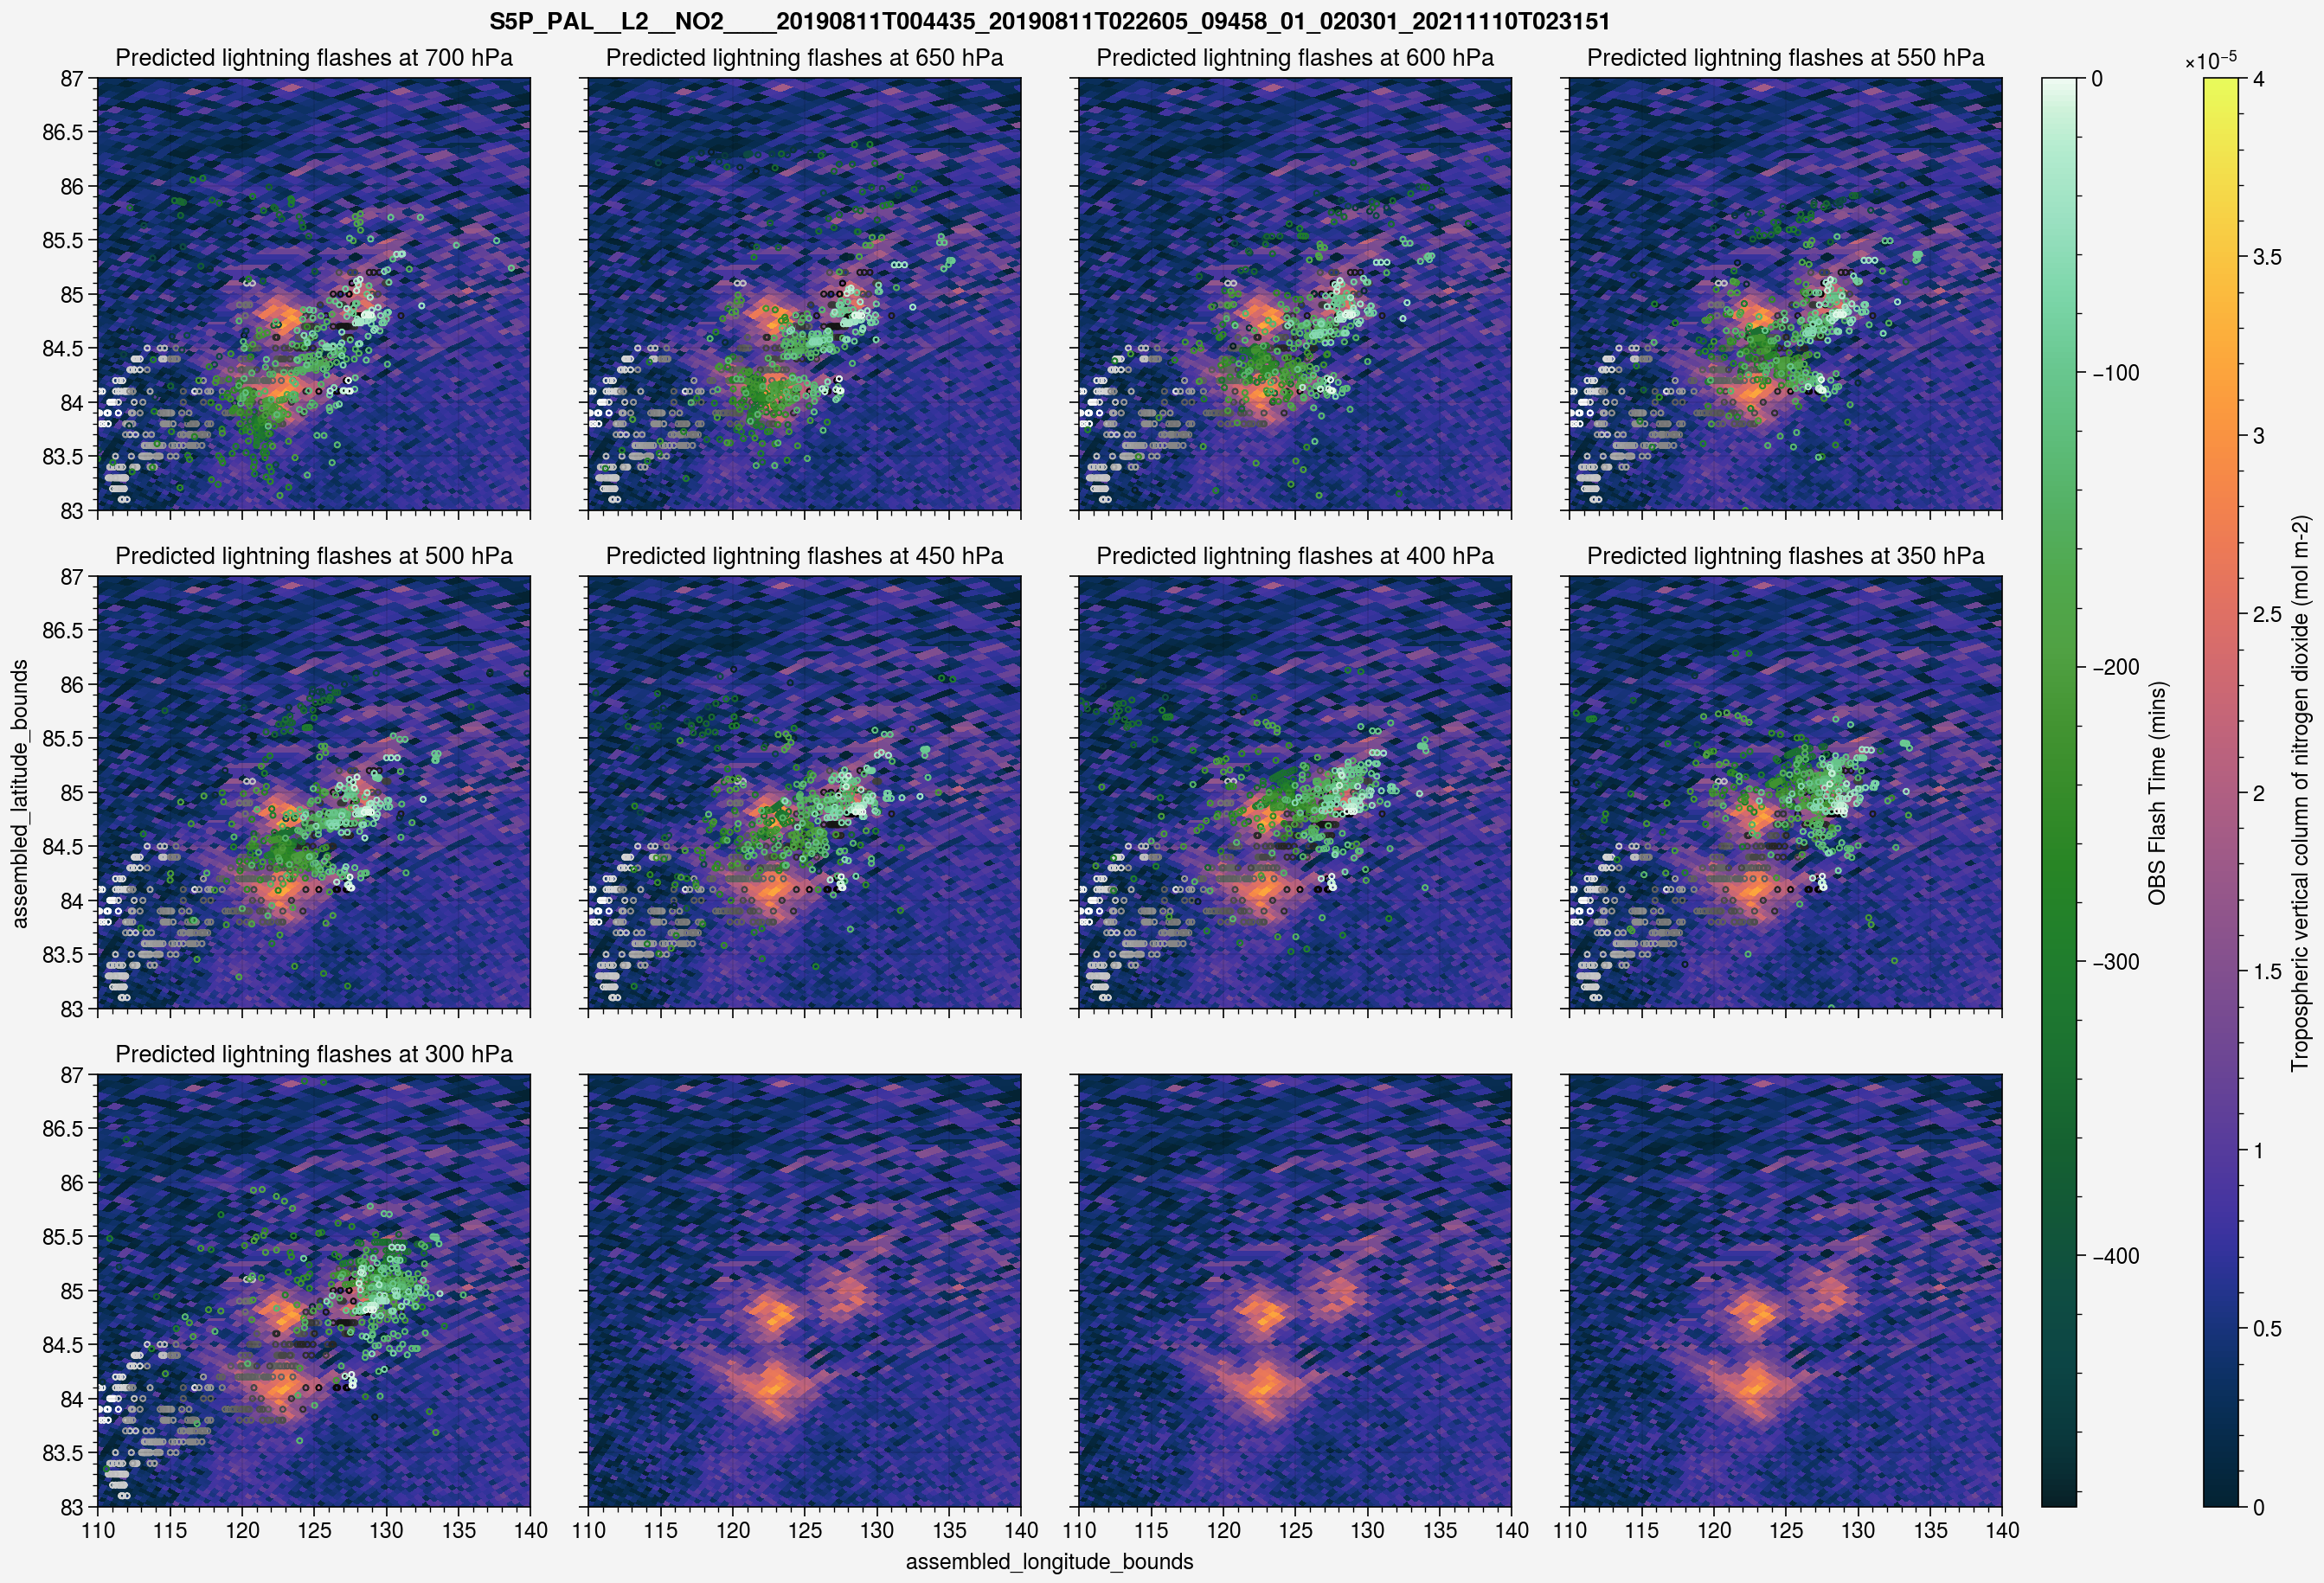

In [8]:
import numpy as np
fig, axs = pplt.subplots(nrows=int(np.ceil(len(ds_lightning.level)/4)), ncols=4)

levels = ds_lightning.level

m = axs.pcolormesh(ds_tropomi['assembled_lon_bounds'],
               ds_tropomi['assembled_lat_bounds'],
               ds_tropomi['nitrogendioxide_tropospheric_column'],
               vmin=0, vmax=4e-5,
               cmap='Thermal', discrete=False,
            #    cmap_kw = {'left': 0.05, 'right': 1},
               )

for index, level in enumerate(ds_lightning.level.values):
    s = plot_scatter(axs[index], ds_lightning, level)

fig.colorbar([s], loc='r', label='OBS Flash Time (mins)')
fig.colorbar(m[0], loc='r')
axs.format(xlim=(110, 140), ylim=(83, 87), suptitle=ds_tropomi.attrs['s5p_filename'].split('.')[0])
# fig.savefig(f"{ds_tropomi.attrs['s5p_filename'].replace('.nc', '.jpg')}", dpi=300)